# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption




In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)


In [26]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [27]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


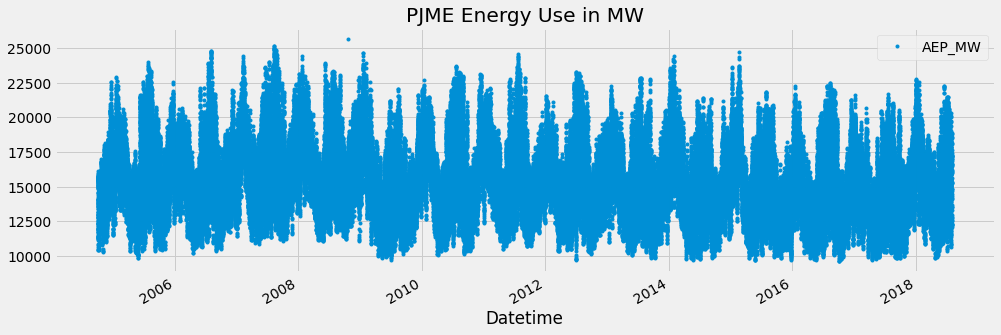

In [28]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AEP Energy Use in MW')
plt.show()

# Train / Test Split

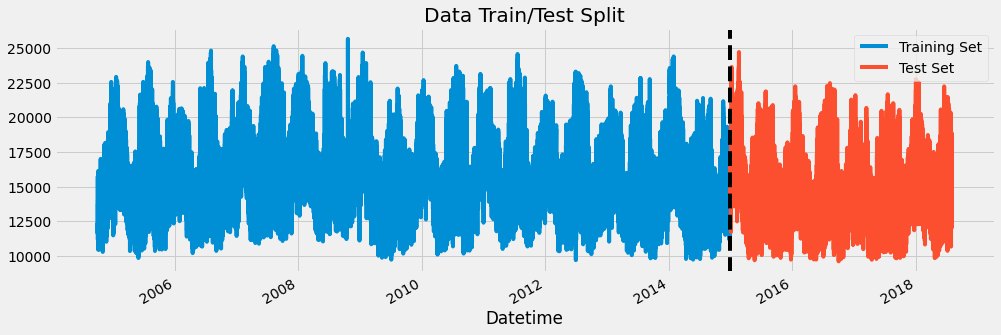

In [29]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

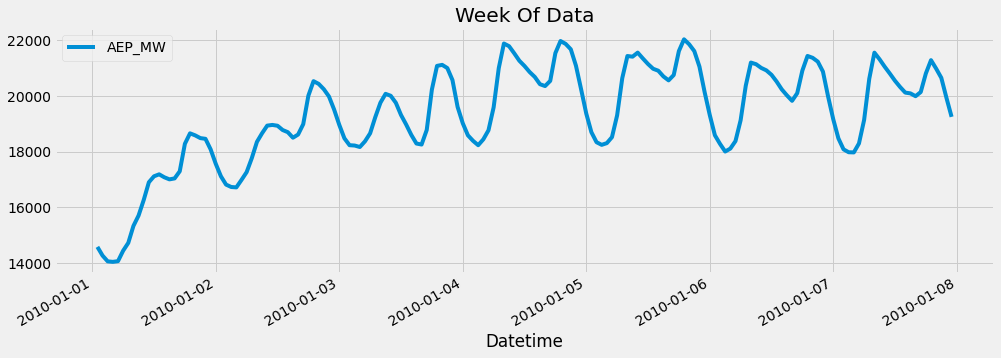

In [30]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [31]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

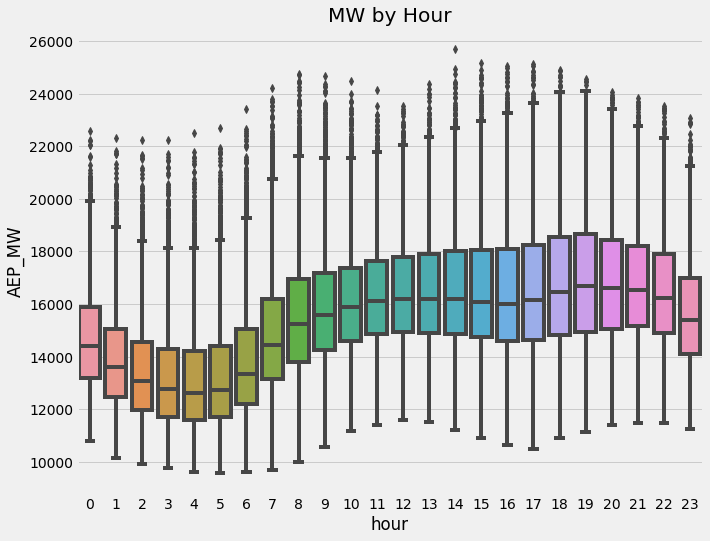

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

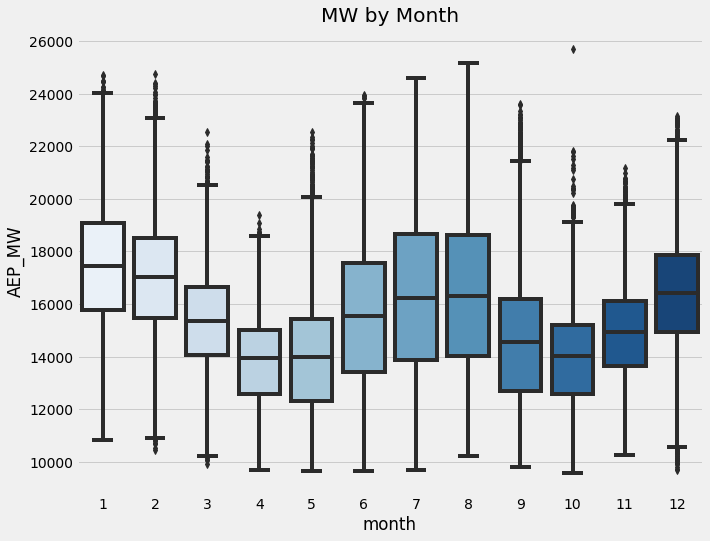

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [34]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [35]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[17:47:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15793.2	validation_1-rmse:14861.3
[100]	validation_0-rmse:6033.9	validation_1-rmse:5144.93
[200]	validation_0-rmse:2702.82	validation_1-rmse:2158.5
[300]	validation_0-rmse:1754.97	validation_1-rmse:1666.22
[400]	validation_0-rmse:1516.42	validation_1-rmse:1658.11
[500]	validation_0-rmse:1430.96	validation_1-rmse:1665.27
[600]	validation_0-rmse:1388.51	validation_1-rmse:1666.47
[700]	validation_0-rmse:1358.13	validation_1-rmse:1667.29
[800]	validation_0-rmse:1334.84	validation_1-rmse:1668.95
[900]	validation_0-rmse:1318.92	validation_1-rmse:1660.61
[999]	validation_0-rmse:1304.95	validation_1-rmse:1656.82


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

# Forecast on Test

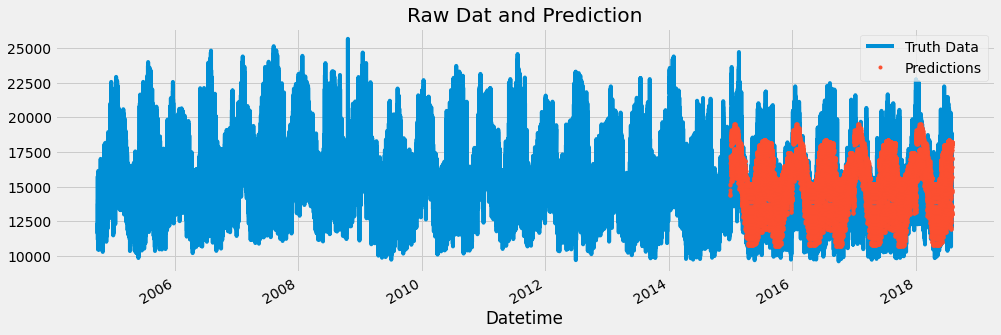

In [39]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

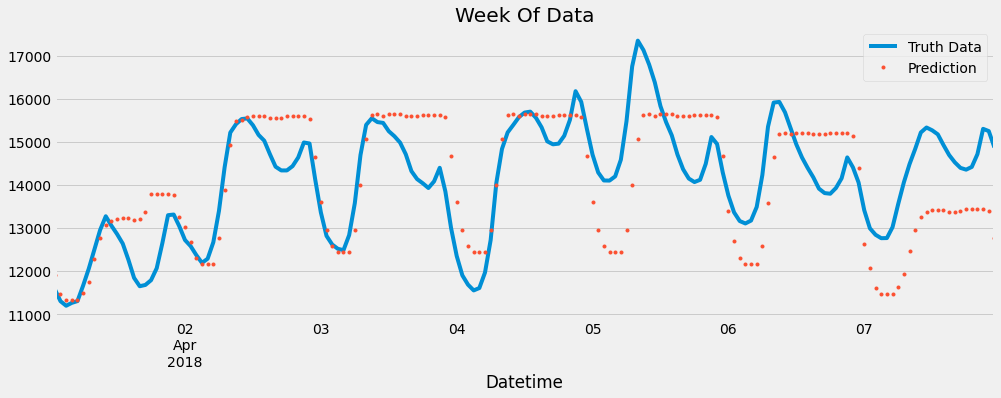

In [40]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [41]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1656.83


# Calculate Error
- Look at the worst and best predicted days

In [42]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    4866.717204
2015-02-20    4731.950724
2017-01-22    4564.146729
2017-01-21    4414.631022
2015-12-25    4338.827637
2015-12-24    4213.529989
2017-01-02    4206.791667
2017-02-12    4163.510417
2017-02-07    4157.510498
2017-12-31    4119.320679
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# The End